In [21]:
#Connecting google drive
#You have to upload the data on your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unziping the require files, after connecting to google drive you have give the file path below 
!unzip "/content/drive/MyDrive/Pear.zip"

In [ ]:
#make a new directory for JPEG files
os.mkdir("JPEG_IMG")

In [6]:
#tensorflow unable to handle JPG type file so we have to convert JPG to JPEG and save them on specific folder
from PIL import Image
import os
from tqdm import tqdm


DEST = "/content/JPEG_IMG"
DATADIR = "/content/Pear/leaves"
CATEGORIES = ['curl', 'healthy', 'slug', 'spot']

for category in CATEGORIES:
  os.mkdir(os.path.join(DEST,category))
  dest_path = os.path.join(DEST,category)
  path = os.path.join(DATADIR,category)  
  class_num = CATEGORIES.index(category)  

  for img in tqdm(os.listdir(path)):
    if "._" in img:
      img = img.split("._")[1]
    # print(os.path.join(path,img))
    # print(os.path.join(path,img).split(".jpg")[0]+'.jpeg')

    im1 = Image.open(os.path.join(path,img))
    im1.save(os.path.join(dest_path,img).split(".jpg")[0]+'.jpeg')

100%|██████████| 1768/1768 [16:38<00:00,  1.77it/s]


In [7]:
#Import different kinds of library
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [8]:
#Load the dataset the JPES files what we converted before
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/JPEG_IMG',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3006 files belonging to 4 classes.


In [9]:
#Class name in my dataset
class_name=dataset.class_names
class_name


['curl', 'healthy', 'slug', 'spot']

In [10]:
#image shape 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 224, 224, 3)
[2 3 2 2 2 2 3 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 2 2 2 3]


In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[ 89.9898   149.9898    87.9898  ]
  [ 66.18367  115.53061   41.387753]
  [ 47.418365  93.418365  18.418365]
  ...
  [123.73451  183.73451   59.734516]
  [139.37668  195.74393   58.315636]
  [152.663    199.663     59.663002]]

 [[142.08163  191.0204   136.07141 ]
  [101.70408  150.13264   72.84693 ]
  [ 85.7959   135.7959    39.224476]
  ...
  [108.540794 167.54079   47.540794]
  [104.52066  159.8068    45.37808 ]
  [104.58161  162.58162   49.58161 ]]

 [[158.43877  201.43877  156.29591 ]
  [135.89795  183.18367  118.32653 ]
  [ 94.06122  152.06122   50.632645]
  ...
  [ 96.285645 151.28564   33.714355]
  [ 86.35618  141.23376   24.601017]
  [ 99.11239  158.11238   42.112385]]

 ...

 [[119.18422   97.18422   56.184223]
  [135.16373  114.592285  66.30657 ]
  [140.57178  117.57178   65.57178 ]
  ...
  [173.00989  211.72424  128.15295 ]
  [178.57178  212.       132.54124 ]
  [181.21484  213.64307  128.42896 ]]

 [[110.93868   90.93868   53.938686]
  [127.82649  109.82649   62.96934 ]


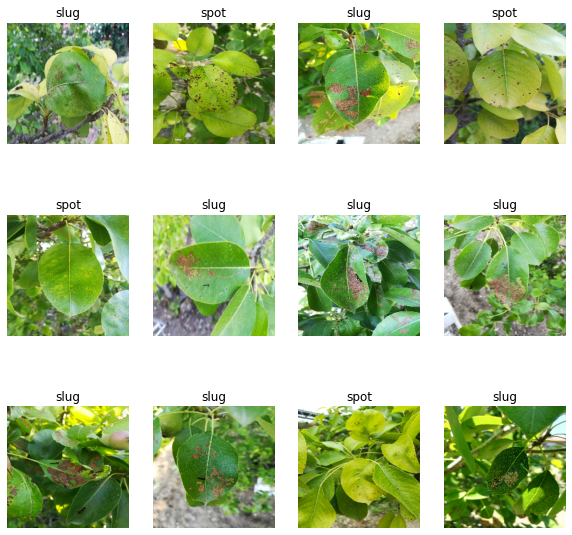

In [12]:
#some data visualization for understanding
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[labels_batch[i]])
    plt.axis("off")


In [13]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#Resnet50 model
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')


for layer in conv_base.layers:
    layer.trainable = False


x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


Training accuracy = 94.47
Validation accuracy = 90.97

In [20]:
#Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
65/65 [==============================] - 485s 7s/step - loss: 0.6739 - accuracy: 0.7411 - val_loss: 0.5639 - val_accuracy: 0.7465
Epoch 2/10
65/65 [==============================] - 391s 6s/step - loss: 0.4086 - accuracy: 0.8253 - val_loss: 0.3739 - val_accuracy: 0.8368
Epoch 3/10
65/65 [==============================] - 394s 6s/step - loss: 0.3634 - accuracy: 0.8455 - val_loss: 0.3478 - val_accuracy: 0.8524
Epoch 4/10
65/65 [==============================] - 437s 7s/step - loss: 0.2932 - accuracy: 0.8730 - val_loss: 0.3437 - val_accuracy: 0.8316
Epoch 5/10
65/65 [==============================] - 394s 6s/step - loss: 0.2864 - accuracy: 0.8744 - val_loss: 0.2862 - val_accuracy: 0.8715
Epoch 6/10
65/65 [==============================] - 391s 6s/step - loss: 0.2699 - accuracy: 0.8821 - val_loss: 0.2569 - val_accuracy: 0.9080
Epoch 7/10
65/65 [==============================] - 390s 6s/step - loss: 0.2462 - accuracy: 0.8961 - val_loss: 0.3604 - val_accuracy: 0.8351
Epoch 8/10
65

Test accuracy is = 92.9%

In [22]:
#Testing the model
scores = model.evaluate(test_ds)

11/11 [==============================] - 153s 5s/step - loss: 0.1845 - accuracy: 0.9290


first image to predict
actual label: slug
predicted label: slug


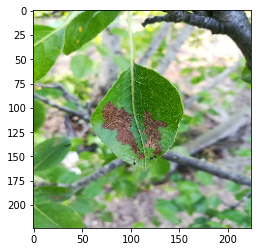

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])


In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Visualizing the result

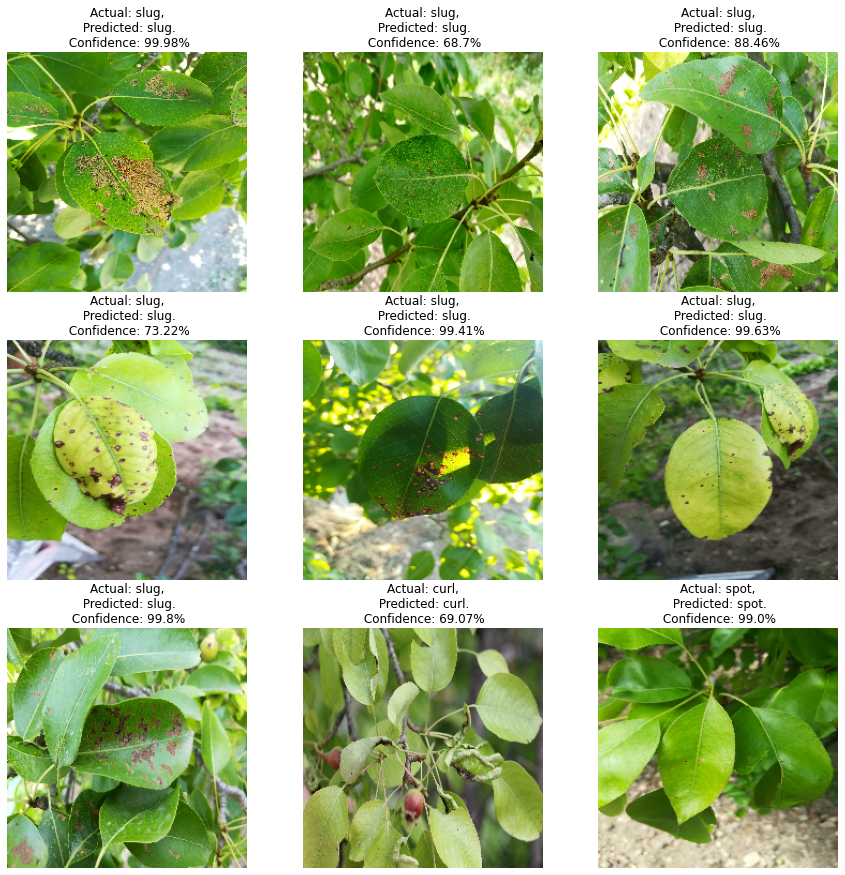

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


Traing graphs

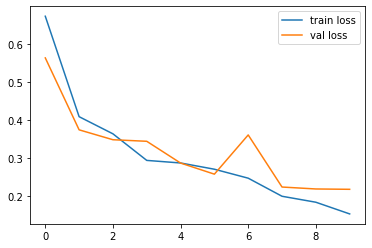

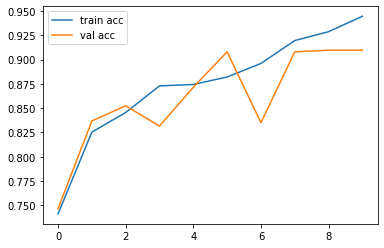

<Figure size 432x288 with 0 Axes>

In [48]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
predicted = []
actual = []
for images, labels in test_ds:
  for i in range(32):
    predicted_class, confidence =predict(model, images[i].numpy())
    predicted.append(predicted_class)
    actual.append(class_name[labels[i]])
    print(predicted_class,class_name[labels[i]])


Some performance Scores

In [69]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(actual, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))



precision: [1.         1.         0.92996109 0.9125    ]
recall: [1.         1.         0.97154472 0.8021978 ]
fscore: [1.         1.         0.95029821 0.85380117]


All about confusion matrix

In [81]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

con_matrix = confusion_matrix(actual, predicted)
con_matrix

array([[  8,   0,   0,   0],
       [  0,   7,   0,   0],
       [  0,   0, 239,   7],
       [  0,   0,  18,  73]])

In [82]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

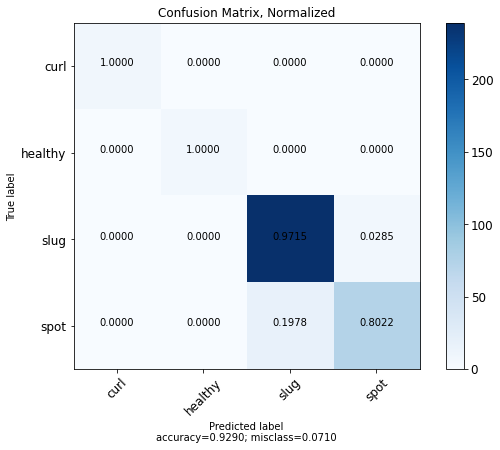

In [83]:
plot_confusion_matrix(cm           = con_matrix, 
                      normalize    = True,
                      target_names = ['curl', 'healthy', 'slug', 'spot'],
                      title        = "Confusion Matrix, Normalized")